In [15]:
from scipy.optimize import curve_fit
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import locale
import datetime

locale.setlocale(locale.LC_TIME, 'es_ES')

'es_ES'

In [16]:
raw_data = pd.read_csv("casos_chile.csv")
proc_data = raw_data[["Casos Nuevos"]]
proc_data.rename(columns={"Casos Nuevos":"Casos nuevos"}, inplace=True)
proc_data.index.names = ["Dias"]
proc_data.reset_index(inplace=True)

totalCasos = []
casosAcumulados = 0
for index, value in proc_data["Casos nuevos"].iteritems():
    casosAcumulados += value
    totalCasos.append(casosAcumulados)
proc_data["Casos totales"] = totalCasos

/opt/apps/easybuild/software/Anaconda3/2019.03/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/apps/easybuild/software/Anaconda3/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
# Considerar sólo desde los 100 casos confirmados
#proc_data = proc_data.iloc[13:]

In [18]:
def exponential_model(x, a, b):
    return a*np.exp(x*b)

param, paramCovariance = curve_fit(exponential_model, proc_data["Dias"], proc_data["Casos totales"])
exponentialFit = param[0]*np.exp(proc_data["Dias"]*param[1])

#Calculo de error
stdError = np.sqrt(np.diag(paramCovariance))
errorLowerLimit = (param[0]-stdError[0])*np.exp(proc_data["Dias"]*(param[1]-stdError[1]))
errorUpperLimit = (param[0]+stdError[0])*np.exp(proc_data["Dias"]*(param[1]+stdError[1]))

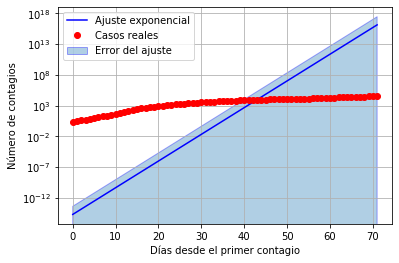

In [19]:
figure = plt.figure()
exponentialGrowthPlot = figure.add_subplot(111)
exponentialGrowthPlot.fill_between(proc_data["Dias"], errorLowerLimit, errorUpperLimit, alpha=0.35, ec='blue', label="Error del ajuste")
exponentialGrowthPlot.plot(proc_data["Dias"], exponentialFit, color="blue", label="Ajuste exponencial")
exponentialGrowthPlot.plot(proc_data["Dias"], proc_data["Casos totales"], 'o', color ='red', label="Casos reales")

plt.xlabel('Días desde el primer contagio')
plt.ylabel('Número de contagios')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

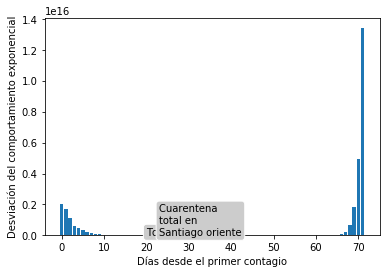

Desviación calculada con la fórmula:

<IPython.core.display.Math object>


$E_i$: Valor esperado

$O_i$: Valor observado


In [20]:
exponentialDeviation = []
for obsY, predY in zip(proc_data["Casos totales"].to_numpy(), np.array(exponentialFit)):
    exponentialDeviation.append(np.power(obsY-predY, 2)/predY)    

figure = plt.figure()
exponentialDeviationPlot = figure.add_subplot(111)
exponentialDeviationPlot.bar(proc_data["Dias"], exponentialDeviation)

exponentialDeviationPlot.annotate(s='', xy=(20.5, 0), xytext=(20.5,100), arrowprops=dict(arrowstyle='->'))
exponentialDeviationPlot.annotate('Toque de queda', (20, 100), bbox=dict(boxstyle="round",
                            fc=(0.8, 0.8, 0.8),
                            ec=(1., 1., 1.)))

exponentialDeviationPlot.annotate(s='', xy=(23.5, 0), xytext=(23.5,50), arrowprops=dict(arrowstyle='->'))
exponentialDeviationPlot.annotate('Cuarentena \ntotal en \nSantiago oriente', (23, 50), bbox=dict(boxstyle="round",
                            fc=(0.8, 0.8, 0.8),
                            ec=(1., 1., 1.)))

plt.xlabel('Días desde el primer contagio')
plt.ylabel('Desviación del comportamiento exponencial')
plt.show()
display(Markdown("Desviación calculada con la fórmula:"))
display(Math(r'dev = \frac{(E_i - O_i)^2}{E_i}'))
display(Markdown(r"""
$E_i$: Valor esperado

$O_i$: Valor observado
"""))

In [21]:
ICURate = 362/5546 #Fuente: ADN Radio
ICURateDate = "8 de Abril"
ICUBeds = 1698 #Fuente: CIPER

daysToDoomsday = 1/param[1] * np.log(ICUBeds/(ICURate*param[0]))
daysToDoomsdayOptimist = 1/(param[1]-stdError[1]) * np.log(ICUBeds/(ICURate*(param[0]-stdError[0])))
zeroDay = datetime.date(2020,3,3)

doomsDay = zeroDay + datetime.timedelta(days=daysToDoomsday)
doomsDayStr = doomsDay.strftime("%A %d de %B")

doomsDayOptimist = zeroDay + datetime.timedelta(days=daysToDoomsdayOptimist)
doomsDayOptimistStr = doomsDayOptimist.strftime("%A %d de %B")

/opt/apps/easybuild/software/Anaconda3/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


ValueError: cannot convert float NaN to integer

In [ ]:
proyectedGrowthData = ICURate*param[0]*np.exp((np.arange(1, daysToDoomsday+5))*param[1])
proyectedGrowthDataOptimist = ICURate*(param[0]-stdError[0])*np.exp((np.arange(1, daysToDoomsday+5))*(param[1]-stdError[1]))

figure = plt.figure()
proyectedGrowthPlot = figure.add_subplot(111)
proyectedGrowthPlot.plot(np.arange(1, daysToDoomsday+5), proyectedGrowthData, label="Pacientes UCI, proyección pesimista", color="C1")
proyectedGrowthPlot.plot(np.arange(1, daysToDoomsday+5), proyectedGrowthDataOptimist, label="Pacientes UCI, proyección optimista", color="C2")
proyectedGrowthPlot.arrow(0, ICUBeds, daysToDoomsday+5, 0, color='red', linestyle="-.", linewidth=2.0)
proyectedGrowthPlot.annotate('N° de camas UCI/UTI', (2, ICUBeds), bbox=dict(boxstyle="round", alpha=0.8,
                            fc=(0.9, 0.0, 0.0),
                            ec=(1., 1., 1.)))
proyectedGrowthPlot.annotate(s='', xy=(daysToDoomsday, ICUBeds), xytext=(daysToDoomsday,ICUBeds+800), arrowprops=dict(arrowstyle='->'))
proyectedGrowthPlot.annotate(doomsDayStr, (daysToDoomsday, ICUBeds+800), bbox=dict(boxstyle="round", alpha=0.8,
                            fc="C1",
                            ec=(1., 1., 1.)))
proyectedGrowthPlot.annotate(s='', xy=(daysToDoomsdayOptimist, ICUBeds), xytext=(daysToDoomsdayOptimist,ICUBeds-800), arrowprops=dict(arrowstyle='->'))
proyectedGrowthPlot.annotate(doomsDayOptimistStr, (daysToDoomsdayOptimist, ICUBeds-800), bbox=dict(boxstyle="round", alpha=0.8,
                            fc="C2",
                            ec=(1., 1., 1.)))
plt.xlabel('Días desde el primer contagio')
plt.ylabel('Número de pacientes UCI/UTI')
plt.legend()
plt.grid()
plt.show()

In [ ]:
nextDayEstimate = int(exponential_model(len(proc_data), param[0], param[1])
                     -exponential_model(len(proc_data)-1, param[0], param[1]))
nextDayEstimateOptimist = int(exponential_model(len(proc_data), param[0]-stdError[0],
                                                  param[1]-stdError[1])
                             -exponential_model(len(proc_data)-1, param[0]-stdError[0],
                                                  param[1]-stdError[1]))
nextDay = zeroDay + datetime.timedelta(days=len(proc_data))
nextDayStr = nextDay.strftime("%A %d de %B")

display(Markdown("Para el día {} se proyectan entre {} y {} nuevos casos.".format(nextDayStr, nextDayEstimateOptimist, nextDayEstimate)))

In [ ]:
proc_data